In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc1

In [0]:
!pip install tf-nightly-gpu

In [0]:
!pip install import_ipynb

In [0]:
# mount to your google drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

In [0]:
#ipynb 모듈 불러오기 위한 설정(model import)
import sys
sys.path.append('/content/gdrive/My Drive')
sys.path

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence

from PIL import Image
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2

import import_ipynb
from model_class_cp import EFFICIENTNET_B0_7, MobileNet_V1, VggNet, ResNet, DenseNet

print(tf.__version__)

## Setting(Hyper parameter, PATH etc..) 

In [0]:
#이미지 경로 설정.
train_PATH = '/content/gdrive/My Drive/dataset/train'
val_PATH = '/content/gdrive/My Drive/dataset/val'
test_PATH = '/content/gdrive/My Drive/dataset/test'

#이미지 하이퍼파라미터.
train_batch = 10
val_batch = 10
test_batch = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

#훈련 하이퍼파라미터.
train_step = 80
val_step = 20
epoch = 300
history = {}

#데이터셋(Augment part).
aug_dic = dict(rotation=True,
               flip_left_right = False,
               flip_up_down = True,
               color = False,
               zoom = True)

## model select(input model index) 

In [0]:
def get_models(model_select):
  if model_select == 1:
    return VggNet.vgg_11()
  elif model_select == 2:
    return VggNet.vgg_13()
  elif model_select == 3:
    return VggNet.vgg_16()
  elif model_select == 4:
    return VggNet.vgg_19()
  elif model_select == 5:
    return VggNet.se_vgg_16()
  elif model_select == 6:
    return VggNet.se_vgg_19()
  elif model_select == 7:
    return ResNet.resnet_18()
  elif model_select == 8:
    return ResNet.resnet_34()
  elif model_select == 9:
    return ResNet.resnet_50()
  elif model_select == 10:
    return ResNet.resnet_101()
  elif model_select == 11:
    return ResNet.resnet_152()
  elif model_select == 12:
    return ResNet.se_resnet_50()
  elif model_select == 13:
    return ResNet.se_resnet_101()
  elif model_select == 14:
    return ResNet.se_resnet_152()
  elif model_select == 15:
    return DenseNet.DenseNet_121()
  elif model_select == 16:
    return DenseNet.DenseNet_169()
  elif model_select == 17:
    return DenseNet.DenseNet_201()
  elif model_select == 18:
    return DenseNet.DenseNet_265()
  elif model_select == 19:
    return DenseNet.se_DenseNet_121()
  elif model_select == 20:
    return DenseNet.se_DenseNet_169()
  elif model_select == 21:
    return DenseNet.se_DenseNet_201()
  elif model_select == 22:
    return DenseNet.se_DenseNet_265()
  elif model_select == 23:
    return EFFICIENTNET_B0_7.efficient_net_b0()
  elif model_select == 24:
    return EFFICIENTNET_B0_7.efficient_net_b1()
  elif model_select == 25:
    return EFFICIENTNET_B0_7.efficient_net_b2()
  elif model_select == 26:
    return EFFICIENTNET_B0_7.efficient_net_b3()
  elif model_select == 27:
    return EFFICIENTNET_B0_7.efficient_net_b4()
  elif model_select == 28:
    return EFFICIENTNET_B0_7.efficient_net_b5()
  elif model_select == 29:
    return EFFICIENTNET_B0_7.efficient_net_b6()
  elif model_select == 30:
    return EFFICIENTNET_B0_7.efficient_net_b7()
  elif model_select == 31:
    return MobileNet_V1.MobileNet_V1()
  elif model_select == 32:
    return MobileNet_V1.se_MobileNet_V1()
  else:
    raise ValueError("The model_index does not exist.")

In [0]:
model_select = int(input('Please enter the model index you want to use.'))

Please enter the model index you want to use.3


In [0]:
get_model = get_models(model_select)

# Dataset Directory & Data loader Implementation

dataset/  
├── train  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├──cat -- 8500장  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└──dog -- 8500장  
├── val  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├──cat -- 2000장  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└──dog -- 2000장  
└── test  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├──cat -- 2000장  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└──dog -- 2000장  

In [0]:
# 데이터 확인 함수
def check_images(train_path, val_path, test_path):
  train_cat_path = os.path.join(train_path,"cat")
  train_dog_path = os.path.join(train_path,"dog")
  val_cat_path = os.path.join(val_path,"cat")
  val_dog_path = os.path.join(val_path,"dog")
  test_cat_path = os.path.join(test_path,"cat")
  test_dog_path = os.path.join(test_path,"dog")

  num_cats_tr = len(os.listdir(train_cat_path))
  num_dogs_tr = len(os.listdir(train_dog_path))
  num_cats_val = len(os.listdir(val_cat_path))
  num_dogs_val = len(os.listdir(val_dog_path))
  num_cats_test = len(os.listdir(test_cat_path))
  num_dogs_test = len(os.listdir(test_dog_path))
  label = ['train', 'valid','test']
  cat = [num_cats_tr,num_cats_val,num_cats_test]
  dog = [num_dogs_tr,num_dogs_val,num_dogs_test]

  plt.rcParams["font.size"] = 12

  plt.figure(figsize=(12,8))

  x = np.arange(len(label))

  plt.bar(x-0.15, cat, label='cat', width=0.3, color='#FF0000')
  plt.bar(x+0.15, dog, label='dog', width=0.3, color='#0000FF')
  plt.legend()
  plt.xticks(x, label)
  plt.ylabel('Number of data')
  plt.title('Compare DATASETS')

  plt.show()
  return

In [0]:
# 데이터 로더 동작 확인
def data_info_print(data_gen, idx):
  batch = data_gen.__getitem__(idx)
  print(type(batch), type(batch[0]), type(batch[1]))
  # 변경
  print(len(batch[0]), len(batch[1]))
  plt.figure(figsize=(20,8))
  for i in range(len(batch[0])):
    plt.subplot(2,5,i+1)
    # 변경 
    plt.imshow(batch[0][i])
    
  print('label :', batch[1])
  print(type(batch[0][0]), type(batch[1][0]))

In [0]:
#Augment
class Augment:
  # rotation
  def __init__(self, rotation, flip_left_right, flip_up_down, color, zoom):
    self.rotation = rotation
    self.flip_left_right = flip_left_right
    self.flip_up_down = flip_up_down
    self.color = color
    self.zoom = zoom

  def augmentation(self, img, size):
    if self.rotation:
      img=tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # flip_left_right
    if self.flip_left_right:
      img = tf.image.flip_left_right(image=img)

    # flip_up_down
    if self.flip_up_down:
      img = tf.image.flip_up_down(image=img)

    # color augmentation
    if self.color:
      img = tf.image.random_hue(image=img, max_delta = 0.4)
      img = tf.image.random_contrast(image=img,lower=0.7,upper=1.3)
      img = tf.image.random_saturation(image=img, lower=0.6, upper=1.6)
      img = tf.image.random_brightness(image=img, max_delta=0.05)

    # zoom
    if self.zoom:
      scales = list(np.arange(0.8, 1.0, 0.01))
      boxes = np.zeros((len(scales), 4))
      for i, scale in enumerate(scales):
          x1 = y1 = 0.5 - (0.5 * scale)
          x2 = y2 = 0.5 + (0.5 * scale)
          boxes[i] = [x1, y1, x2, y2]
      img = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(224, 224))
      choice = tf.random.uniform(shape=[], minval=0, maxval=19, dtype=tf.int64)
      return img[choice]
    return img

In [0]:
class Dataset_file_ver:
    def __init__(self, augment = None, path='./', target_size=(224,224)):
      self.dir_path = path
      self.target_size = target_size
      self.Image_list = []
      self.Image_label = []
      self.augment = augment
      for index in range(len(os.listdir(self.dir_path))):
          # 클래스 라벨 추가 (고양이 : 0. , 개 : 1.)
          self.label = 1.0
          if os.listdir(self.dir_path)[index].startswith('cat'):
              self.label = 0.0
          # 이미지 경로를 저장해 나중에 배치만큼만 이미지를 불러온다.
          self.Image_list.append(os.path.join(self.dir_path, os.listdir(self.dir_path)[index]))
          # 클래스 라벨은 이미지 경로 순서대로 넣어준다.
          self.Image_label.append(self.label)
      print('Found {} images'.format(len(self.Image_list)))
      
    def __len__(self):
      # 이미지 경로를 담은 리스트 전체를 리턴한다.
      return len(self.Image_list)

    def __getitem__(self, idx):
      # 호출 마다 한장의 이미지와 각 클래스 라벨을 같이 넘겨준다.
      img = image.load_img(self.Image_list[idx], target_size=self.target_size)
      img = image.img_to_array(img)
      img = img/255.0
      # image_augmentation
      if self.augment:
        img = self.augment.augmentation(img, self.target_size)
      #image = image.resize(self.target_size)
      return img, self.Image_label[idx]

In [0]:
class Dataset_dir_ver:
    def __init__(self, augment = None, path='./', target_size=(224,224)):
      self.dir_path = []
      self.target_size = target_size
      self.Image_list = []
      self.Image_label = []
      self.augment = augment

      for in_dir in os.listdir(path):
        self.dir_path.append(os.path.join(path,in_dir))

      for i in range(len(self.dir_path)):
        for index in range(len(os.listdir(self.dir_path[i]))):
            # 클래스 라벨 추가 (고양이 : 0. , 개 : 1.)
            self.label = 1.0
            if os.listdir(self.dir_path[i])[index].startswith('cat'):
                self.label = 0.0
            # 이미지 경로를 저장해 나중에 배치만큼만 이미지를 불러온다.
            self.Image_list.append(os.path.join(self.dir_path[i], os.listdir(self.dir_path[i])[index]))
            # 클래스 라벨은 이미지 경로 순서대로 넣어준다.
            self.Image_label.append(self.label)
      print('Found {} images'.format(len(self.Image_list)))

    def __len__(self):
      # 이미지 경로를 담은 리스트 전체를 리턴한다.
      return len(self.Image_list)

    def __getitem__(self, idx):
      # 호출 마다 한장의 이미지와 각 클래스 라벨을 같이 넘겨준다.
      img = image.load_img(self.Image_list[idx], target_size=self.target_size)
      img = image.img_to_array(img)
      img = img/255.0
      # image_augmentation
      if self.augment:
        img = self.augment.augmentation(img, self.target_size)
      #image = image.resize(self.target_size)
      # 변경
      return img, self.Image_label[idx]

In [0]:
class Data_Loader(Sequence):

    def __init__(self, dataset, batch_size=None, shuffle=False):
      # 데이터셋을 맴버로 가지며 데이터셋을 호출해 배치만큼 사진을 가지고 온다.
      self.dataset = dataset
      self.batch_size = batch_size
      self.shuffle=shuffle
      self.index_list = [idx for idx in range(len(self.dataset))]
      self.idx=0
    def __getitem__(self, idx):
      # 시작과 끝 인덱스 지정 --> 배치 사이즈만큼 for 루프를 실행하며 사진을 넘파이 배열에 저장한다.
      start = idx * self.batch_size
      end = (idx+1) * self.batch_size
      data = []
      label = []
      if self.shuffle:
        np.random.shuffle(self.index_list)
      # 변경
      # 배치사이즈 만큼 사진과 라벨을 리스트에 저장한다.
      for j in range(start,end):
        if j >= len(self.index_list):
          j%=len(self.dataset)
        data.append(self.dataset[self.index_list[j]])
      # 사진은 사진끼리 라벨은 라벨끼리 묶어서 리턴한다.
      #batch = tuple(sample for sample in zip(*data))
      batch = tuple(tf.stack(sample, axis=0) for sample in zip(*data))

      if self.idx >= (len(self.dataset)//self.batch_size):
        self.idx=0
      self.idx +=1
      return batch

    def __call__(self):
      batch = self.__getitem__(self.idx)
      return batch

    def __len__(self):
      # 데이터셋을 크기를 배치 사이즈로 나누어 준다.
        return (len(self.dataset) // self.batch_size)

    def get_batch(self):
      return self.batch_size

# 데이터 확인 & 데이터 로더 생성
* 각각 10장(고양이 5장, 개 5장)을 가지고 있는 디렉토리이며 겹치는 사진은 없습니다.


In [0]:
# 데이터 확인
check_images(train_path=train_PATH, val_path=val_PATH, test_path=test_PATH)

In [0]:
train_augment = Augment(**aug_dic)
train_dataset = Dataset_dir_ver(augment = train_augment, path=train_PATH)
train_data_gen = Data_Loader(dataset=train_dataset, batch_size=train_batch, shuffle=True)

In [0]:
val_dataset = Dataset_dir_ver(path=val_PATH)
val_data_gen = Data_Loader(dataset=val_dataset, batch_size=test_batch, shuffle=True)

In [0]:
test_dataset = Dataset_dir_ver(path=test_PATH)
test_data_gen = Data_Loader(dataset=test_dataset, batch_size=test_batch)

# train, val, test 데이터 로더의 출력 값과 형태, 타입, 갯수(배치 사이즈) augmentation된 사진 확인

In [0]:
data_info_print(train_data_gen,0)

In [0]:
data_info_print(val_data_gen, 399)

<class 'tuple'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
10 10
label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


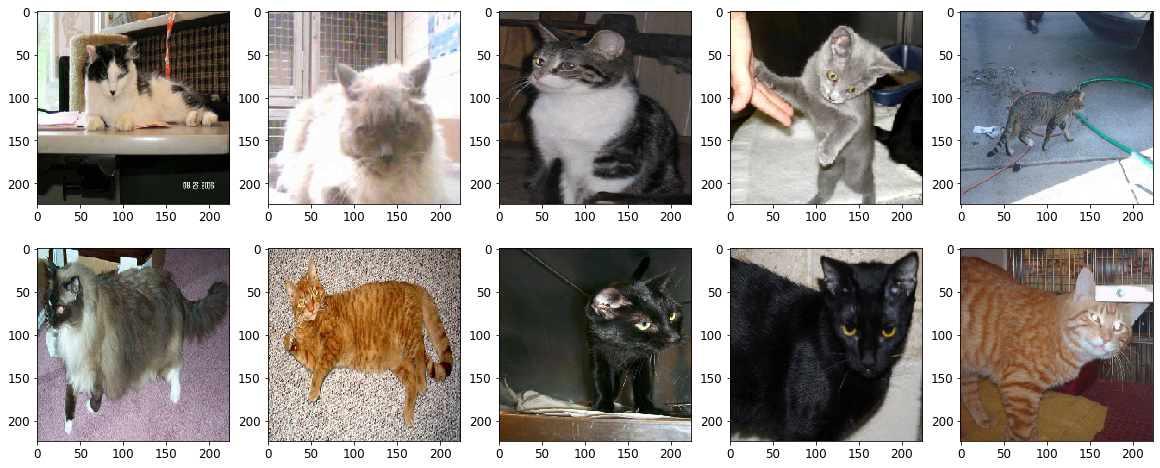

In [0]:
data_info_print(test_data_gen, 1)

# 모델 훈련  
### Using GradientTape


In [0]:
def fit_test(model, train_gen, train_steps, epochs, val_gen, val_steps):
  BATCH_SIZE = train_gen.get_batch()
  # define loss and optimizer
  optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
  loss_func = keras.losses.BinaryCrossentropy()

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

  valid_loss = tf.keras.metrics.Mean(name='valid_loss')
  valid_accuracy = tf.keras.metrics.BinaryAccuracy(name='valid_accuracy')


  train_losses = []
  train_acces = []
  val_losses = []
  val_acces = []


  @tf.function
  def train_step(images, labels):
      with tf.GradientTape() as tape:
          predictions = model(images, training=True)
          loss = loss_func(y_true=labels, y_pred=predictions)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))

      train_loss(loss)
      train_accuracy(labels, predictions)

  @tf.function
  def valid_step(images, labels):

    predictions = model(images, training=False)
    v_loss = loss_func(labels, predictions)

    valid_loss(v_loss)
    valid_accuracy(labels, predictions)
  
  def step_decay(epoch):
   drop = 0.5
   epochs_drop = 10.0
   optimizer.learning_rate = optimizer.learning_rate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   print('step_decay is %6.4f.' % (optimizer.learning_rate))

  LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (2, 0.0005), (3, 0.0001)
  ]

  def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
      return lr
    for i in range(len(LR_SCHEDULE)):
      if epoch == LR_SCHEDULE[i][0]:
        return LR_SCHEDULE[i][1]
    return lr

  def LearningRateScheduler(epoch, lr):
    if not hasattr(optimizer, 'lr'):
      raise ValueError('Optimizer must have a "lr" attribute.')
    # Get the current learning rate from model's optimizer.
    lr = float(tf.keras.backend.get_value(optimizer.learning_rate))
    # Call schedule function to get the scheduled learning rate.
    scheduled_lr = lr_schedule(epoch, lr)
    # Set the value back to the optimizer before this epoch starts
    tf.keras.backend.set_value(optimizer.learning_rate, scheduled_lr)
    print('\nEpoch %05d: Learning rate is %6.4f.' % (epoch, optimizer.learning_rate))

  # start training
  for epoch in range(epochs):
    #LearningRateScheduler(epoch, optimizer.learning_rate)
    step_decay(epoch)

    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    #step = 0
    for step in range(train_steps):
      print('.',end='')
      if step % 100 == 0:
        print()
      images, labels = train_data_gen()
      train_step(images, labels)
    print('x')
    for val_step in range(val_steps):
      print('.', end='')
      if val_step % 100 == 0:
        print()
      valid_images, valid_labels = val_data_gen()
      valid_step(valid_images, valid_labels)
    print('x')
    print("Epoch: {}/{}, train loss: {:.5f}, train accuracy: {:.5f}, "
          "valid loss: {:.5f}, valid accuracy: {:.5f}".format(epoch + 1,
                                                              epochs,
                                                              train_loss.result(),
                                                              train_accuracy.result(),
                                                              valid_loss.result(),
                                                              valid_accuracy.result()))
    train_losses.append(train_loss.result())
    train_acces.append(train_accuracy.result())
    val_losses.append(valid_loss.result())
    val_acces.append(valid_accuracy.result())

  history = {'train_losses': train_losses, 'train_acces': train_acces, 'val_losses': val_losses, 'val_acces': val_acces}
  return history

In [0]:
 def test_eval(model, test_data_gen, test_steps):
  loss_func = keras.losses.BinaryCrossentropy()
  test_loss = tf.keras.metrics.Mean()
  test_accuracy = tf.keras.metrics.BinaryAccuracy()

  @tf.function
  def test_step(images, labels):
      predictions = model(images, training=False)
      t_loss = loss_func(labels, predictions)

      test_loss(t_loss)
      test_accuracy(labels, predictions)

  for step in range(test_steps):
    print('.',end='')
    if step % 100 == 0:
      print()
    test_images, test_labels = test_data_gen()
    test_step(test_images, test_labels)
  print('x')
  print("loss: {:.5f}, test accuracy: {:.5f}".format(test_loss.result(),
                                                      test_accuracy.result()))

  #print("The accuracy on test set is: {:.3f}%".format(test_accuracy.result()*100))

In [0]:
get_model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

In [0]:
get_model.summary()

In [0]:
history = fit_test(model=get_model, 
                   train_gen=train_data_gen, 
                   train_steps=train_step, 
                   epochs=epoch, 
                   val_gen=val_data_gen, 
                   val_steps=val_step)

step_decay is 0.0010.
.
...............................................................................x
.
...................x
Epoch: 1/300, train loss: 0.92894, train accuracy: 0.50875, valid loss: 5.33849, valid accuracy: 0.52500
step_decay is 0.0010.
.
...............................................................................x
.
...................x
Epoch: 2/300, train loss: 0.75450, train accuracy: 0.55000, valid loss: 2.56491, valid accuracy: 0.54000
step_decay is 0.0010.
.
...............................................................................x
.
...................x
Epoch: 3/300, train loss: 0.72167, train accuracy: 0.53125, valid loss: 1.03578, valid accuracy: 0.53000
step_decay is 0.0010.
.
...............................................................................x
.
...................x
Epoch: 4/300, train loss: 0.73692, train accuracy: 0.49125, valid loss: 0.70425, valid accuracy: 0.60500
step_decay is 0.0010.
.
............................................

In [0]:
#300 epoch
test_eval(get_model, test_data_gen, 400)

.
....................................................................................................
....................................................................................................
....................................................................................................
...................................................................................................x
loss: 0.31459, test accuracy: 0.86550


# 저장

In [0]:
get_model.save_weights('/content/gdrive/My Drive/MobileNet_v1_850', save_format='tf')

## 로드

In [0]:
get_model.load_weights('/content/gdrive/My Drive/MobileNet_v1_500')   

# model test


In [0]:
def his_graph(history, epoch):
  acc = history['train_acces']
  val_acc = history['val_acces']

  loss = history['train_losses']
  val_loss = history['val_losses']

  epochs_range = range(epoch)

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.show()

In [0]:
his_graph(history, epoch)

In [0]:
def model_predict(model, test_gen, steps):
  predics=[]
  labels = []
  for step in range(steps):
    image,label = test_gen()
    pred = model(image)
    labels.append(label)
    predics.append(pred)
  re_dic = dict({'pred':predics, 'labels':labels})
  return re_dic

In [0]:
pred_dataset = Dataset_dir_ver(path=test_PATH)
pred_data_gen = Data_Loader(dataset=test_dataset, batch_size=1)

In [0]:
def pred_confusion_matrix(pred, labels):
  pred_int = []
  for i in range(len(pred)):
    if pred[i] > 0.5:
      pred_int.append(1)
    elif pred[i] <= 0.5:
      pred_int.append(0)

  print(len(pred))
  print(len(pred_int))
  print('Confusion Matrix')
  conf_matrix = confusion_matrix(labels, pred_int)
  print(conf_matrix)
  sns.heatmap(conf_matrix,cmap="Blues",annot=True,fmt='g');
  plt.xlabel('predicted value')
  plt.ylabel('true value');

In [0]:
re_dic = model_predict(get_model, pred_data_gen, 4000)
pred = re_dic['pred']
labels = re_dic['labels']
pred = list(map(float,pred))

In [0]:
pred_confusion_matrix(pred, labels)

In [0]:
def model_layer_investigate(models=get_model, layer_index=21):
  for i in range(layer_index):
    weights = models.get_layer(index=).output

    print(i, weights)

In [0]:
def grad_cam(path='/content/gdrive/My Drive/dataset/test/cat/cat.%d.jpg', models=get_model,layer_index=None, layer_weights=None, images_index=10, classes=1):
  plt.figure(figsize=(18, 15))
  for i in range(images_index):
    try:
      path = os.path.join(path%i)
      image = cv2.imread(path)
      img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH)) 
    except Exception as e:
      print(str(e))

    x = img.copy()
    x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    
    grad_model = tf.keras.models.Model(
          [models.inputs], [models.get_layer(index=layer_index).output, models.output]
      )
      
    with tf.GradientTape() as tape:
        inputs = tf.cast(x, tf.float32)
        model_outputs, predictions = grad_model(inputs)
        loss = predictions[:,0]

    grads = tape.gradient(loss, model_outputs)

    guided_grads = (
          tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
    )

    prediction = predictions[0]
    model_outputs = model_outputs[0]
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
      plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
      plt.title('dog %.2f%%' % (prediction*100))

    weights = np.mean(grads, axis=(1, 2))
    weights = weights.reshape(layer_weights, classes)

    cam = (prediction -0.5) * np.matmul(model_outputs, weights)
    cam -= np.min(cam)
    cam /= np.max(cam)
    cam -= 0.2
    cam /= 0.8

    try:
      cam = cv2.resize(np.float32(cam), (224, 224))
    except Exception as e:
      print(str(e))

    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0
    grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
    plt.axis('off')
    plt.imshow(grad_cam[:, :, ::-1])

In [0]:
grad_cam(layer_index=15, layer_weights=1028)

In [0]:
# no inbound nodes error 발생 해결 필요! - Grad CAM(진행 중.)